In [5]:
import syntheticModel
# make a hypercube 
ny,oy,dy = 1500, 0, 5
nx,ox,dx = 100, 0, 5
nz,oz,dz = 30, 0, 5
x_axis = syntheticModel.axis(n=nx, o=ox, d=dx)
y_axis = syntheticModel.axis(n=ny, o=oy, d=dy)
z_axis = syntheticModel.axis(n=nz, o=oz, d=dz)
hyper = syntheticModel.hypercube(axes=[z_axis,y_axis,x_axis])

# make a dictionary of elastic parameters 
basement = {"vp":5000}

# set the primary value 
primary = "vp"

# initialize the geomodel
geomodel = syntheticModel.geoModel(hyper,basement,primary)

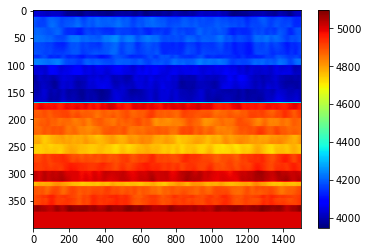

In [6]:
import matplotlib.pyplot as plt      
basicDeposit=syntheticModel.deposit(thick=400, interbedThickAvg=70, 
                 interbedThickDev=22, interbedPropDev=100, \
                           noiseDev=40,noisePersistence=.8,
                 depthGrad=2)
geomodel=basicDeposit.apply(geomodel, thick=200,prop=4800)
geomodel=basicDeposit.apply(geomodel, thick=170,prop=4100)

plt.imshow(geomodel.get().getNdArray()[50,:,:].T,cmap="jet",aspect="auto")
plt.colorbar()

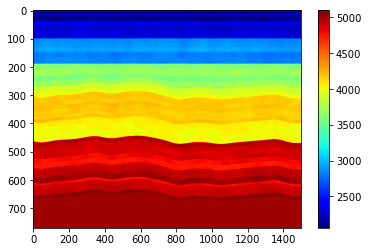

In [7]:
geomodel=syntheticModel.squish(widthInLine=12000,widthCrossLine=2000,maxShift=500,\
                      begFreq=1.,nfreq=2,seed=22).apply(geomodel)
geomodel=basicDeposit.apply(geomodel, thick=80,prop=3700)
geomodel=basicDeposit.apply(geomodel, thick=90,prop=2800)
geomodel=basicDeposit.apply(geomodel, thick=60,prop=2300)
geomodel=basicDeposit.apply(geomodel, thick=40,prop=2100)

plt.imshow(geomodel.get().getNdArray()[50,:,:].T,cmap="jet",aspect="auto")
plt.colorbar()                        

Warning very large theta_die 22.867814. Reduce theta_die or  decrease                 rupture_length or increase radius.
Warning very large theta_die 20.578220. Reduce theta_die or  decrease                 rupture_length or increase radius.
Warning very large theta_die 20.161022. Reduce theta_die or  decrease                 rupture_length or increase radius.


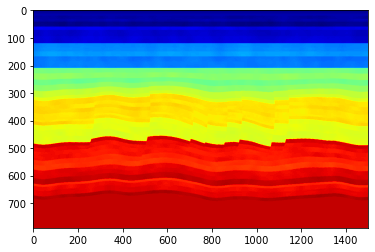

In [8]:
import random

faultOp=syntheticModel.fault(begy=.5,zpos=2000.,
                    begx=.5,azimuth=0, ruptureLength=600,
                    extentInLine=1200,extentCrossline=800,shift=300,
                    angle=15,radius=2000)
def faultIt(basicOp,model,ypos:tuple=(.1,.9),length:tuple=(400,800),
            shift:tuple=(100,400),angle:tuple=(10,18), 
            radius:tuple=(1900,2100),xpos:tuple=(.1,.9),zpos:tuple=(.1,.9)):
    length=random.uniform(length[0],length[1])
    return basicOp.apply(model,begy=random.uniform(ypos[0],ypos[1]),
                         ruptureLength=length,
                         extentInline=length*2.,
                         extentCrossline=length*2,
                         shift=random.uniform(.1,.2)*length,
                         angle=random.uniform(angle[0],angle[1]),
                         begz=random.uniform(zpos[0],zpos[1]) 
                        )
for i in range(3):
    geomodel=faultIt(faultOp,geomodel,zpos=(.7,.9))

for i in range(5):
    geomodel=faultIt(faultOp,geomodel,xpos=(.04,.3))

geomodel=syntheticModel.deposit(prop=2100,thick=20).apply(geomodel)
  
plt.imshow(geomodel.get().getNdArray()[50,:,:].T,cmap="jet",aspect="auto")


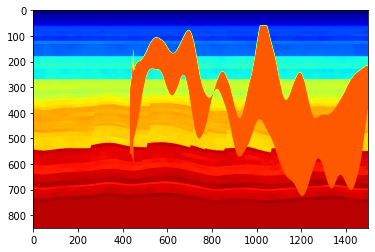

In [11]:
saltF=syntheticModel.salt(salt_value={"vp":4500},seed=29,thickness=.25,\
                     n_octaves_bot=1,n_octaves_top=4, beg2=.3,beg_freq=1.,                    
                     saveSalt=True)
geomodel2=saltF.apply(geomodel)
withWater=syntheticModel.deposit(prop=1450,thick=60).apply(geomodel2)
plt.imshow(withWater.get().getNdArray()[50,:,:].T,cmap="jet",aspect="auto")


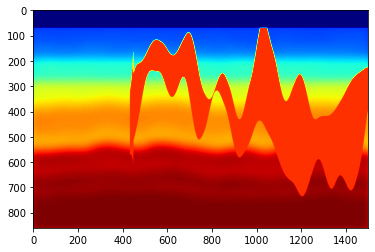

In [12]:
import scipy as sp
import scipy.ndimage
import numba
import numpy as np

@numba.jit(parallel=True)
def padIt(array,ext2,ext1):
    for i2 in numba.prange(ext2):
        for i1 in numba.prange(array.shape[1]):
            array[i2,i1]=array[ext2,i1]
            array[array.shape[0]-i2-1,i1]=array[array.shape[0]-ext2-1,i1]
    for i2  in numba.prange(array.shape[0]):
        for i1 in numba.prange(ext1):
            array[i2,i1]=array[i2,ext1]
            array[i2,array.shape[1]-i1-1]=array[i2,array.shape[1]-ext1-1]
            
@numba.njit(parallel=True)
def smoothAddSaltWater(velS,waterThick,saltV,saltM):

    out=np.zeros((velS.shape[0],velS.shape[1]+waterThick))
    for i2 in numba.prange(velS.shape[0]):
        for i1 in range(waterThick):
            out[i2,i1]=1450.
        for i1 in range(velS.shape[1]):
            if saltM[i2,i1]>0.:
                out[i2,i1+waterThick]=saltV
            else:
                out[i2,i1+waterThick]=velS[i2,i1]
    return out

def padSmoothWater(sigma1,sigma2,vel,waterThick,saltV,saltM):
    ext1=sigma1*2
    ext2=sigma2*2
    velB=np.zeros((vel.shape[0]+2*ext1,vel.shape[1]+ext2*2))
    velB[ext1:ext1+vel.shape[0],ext2:ext2+vel.shape[1]]=vel
    padIt(velB,ext1,ext2)
    sigma=[sigma1,sigma2]
    velB=sp.ndimage.gaussian_filter(velB,sigma,mode="constant")
    return smoothAddSaltWater(velB[ext1:ext1+vel.shape[0],ext2:ext2+vel.shape[1]],\
        waterThick,saltV,saltM)
#sigma = [25, 20]
#velS = sp.ndimage.gaussian_filter(geomodel.get().getNdArray()[50,:,:], sigma, mode='constant')           
smoothed=padSmoothWater(25,20,geomodel.get().getNdArray()[50,:,:],70,4500.,\
                        saltF.salt[0][50,:,:])
plt.imshow(smoothed.T,cmap="jet",aspect="auto")

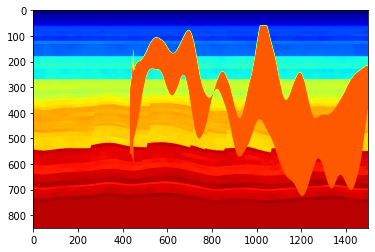

In [13]:
plt.imshow(withWater.get().getNdArray()[50,:,:].T,cmap="jet",aspect="auto")
